# UFC Predictor

Train XGBoost for UFC classification

In [77]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
df = pd.read_csv('../datasets/ufc-clean.csv')

# Dataset shape and basic info
print("UFC dataframe shape:" , df.shape)  

# TODO: encode this columns before exporting dataset in preprocess
# Encode any categorical)
categorical_cols = ['WeightClass', 'BlueStance', 'RedStance', 'Finish']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

UFC dataframe shape: (6528, 83)


In [79]:
# Select all numerical data
numeric_df = df.select_dtypes(include=['number'])

to_drop = ['BlueAvgSigStrLanded', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueTotalRoundsFought',
           'BlueHeightCms', 'BlueReachCms', 'BlueWeightLbs', 'BlueAge', 'FinishRound', 'TotalFightTimeSecs', 
           'UFC_DebutDiff', 'BlueCurrELO']

# Drop the above columns
N = len(to_drop)
for i in range(N):
    if to_drop[i][:4] == "Blue":
        to_drop.append("Red" + to_drop[i][4:])

numeric_df.drop(columns=to_drop, inplace=True)

# Normalize our data
scaler = StandardScaler()
df[numeric_df.columns.to_list()] = scaler.fit_transform(df[numeric_df.columns.to_list()])

## Feature Selection

To prevent overfitting with such a feature rich dataset, we can use methods like Recursive Feature Elimination (RFE) to help us narrow down our selection. This will allow us to choose features which separate data well and further aid prediction.

We'll also create a train/test split.

In [80]:
X = numeric_df.drop(columns=['Winner'], axis=1)
y = numeric_df['Winner']

estimator = RandomForestClassifier(
    random_state=42, 
    n_estimators=10,  
    max_depth=5       
)

rfe = RFE(estimator, n_features_to_select=24)
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
X_selected = X[selected_features]
print(selected_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.1,
    random_state=42
)

Index(['RedExpectedValue', 'BlueExpectedValue', 'BlueCurrentWinStreak',
       'BlueAvgSigStrPct', 'BlueAvgTDPct', 'RedAvgSigStrPct', 'RedAvgTDPct',
       'RedLosses', 'RedWinsByDecision', 'RedDaysSinceLastFight',
       'BlueDaysSinceLastFight', 'ExpectedValueDiff', 'CurrentLoseStreakDiff',
       'CurrentWinStreakDiff', 'AvgSigStrLandedDiff', 'AvgSubAttDiff',
       'AvgTDLandedDiff', 'LossesDiff', 'TotalRoundsFoughtDiff',
       'ReachCmsDiff', 'WeightLbsDiff', 'AgeDiff', 'DaysSinceLastFightDiff',
       'CurrELODiff'],
      dtype='object')


## Training w/ XGBoost

Let's define functions to to fit an XGBoost model and predict the train/test sets. We'll use a confusion
matrix to display our results, beginning with an initial baseline model.

In [81]:
def xgb_predict(model: XGBClassifier, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5):
    # Enable CrossValidation for hyperparameter finetuning
    if useTrainCV:
        xgb_params = model.get_xgb_params()
        xgb_train = xgb.DMatrix(X_train, label=y_train)

        cv_res = xgb.cv(xgb_params, xgb_train,
                    nfold=cv_folds,
                    metrics='auc',
                    early_stopping_rounds=50
        )
        optimal_estimators = cv_res.shape[0]
        model.set_params(n_estimators=optimal_estimators)
        print(f"Best number of estimators = {optimal_estimators}\n")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict the test set
    test_predict = model.predict(X_test)
    test_predprob = model.predict_proba(X_test)[:,1]

    # Print results
    print("Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_predict):.4f}")
    print(f"AUC Score: {roc_auc_score(y_test, test_predprob):.4f}")
    return test_predict


In [82]:
def plot_confusion_matrix(mat: np.ndarray):
    """Plot confusion matrix to display model results"""
    palette = sns.color_palette("crest", as_cmap=True)
    ax = sns.heatmap(mat, 
                    cmap=palette, 
                    annot=True, 
                    fmt="d", 
                    linewidths=0.5, 
                    linecolor='black')

    ax.set_title('AUC Conf. Matrix Results')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ax.set_ylim([0,2])

    ax.invert_yaxis()
    plt.show()

Best number of estimators = 10

Results:
Accuracy: 0.6126
AUC Score: 0.6241


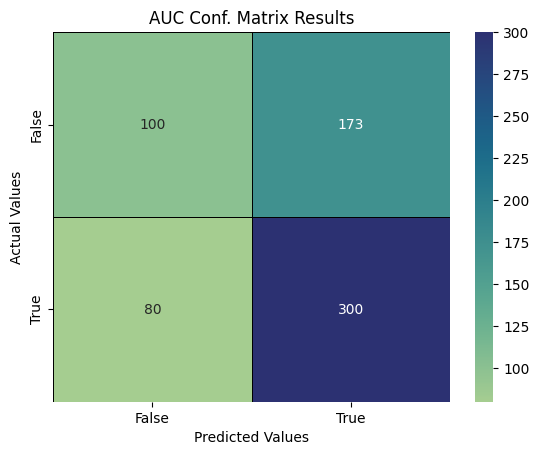

In [83]:
# Train binary classifier for moneyline winner
model_v1 = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='auc')
preds_v1 = xgb_predict(model_v1, X_train, y_train, X_test, y_test)

mat_v1 = confusion_matrix(y_test, preds_v1)
plot_confusion_matrix(mat_v1)